# **How to Train YOLO11 Object Detection Model on a Custom Dataset**

**Step 01 # Install the Ultralytics Package**

In [1]:
!nvidia-smi
!pip install ultralytics
!pip install roboflow

Mon Jan 27 08:55:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P0             24W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**Step 02 # Import All the Requried Libraries**

In [2]:
import ultralytics
from ultralytics import YOLO
from IPython.display import Image
from roboflow import Roboflow
from kaggle_secrets import UserSecretsClient
import os

ultralytics.checks()

Ultralytics 8.3.68 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 6095.9/8062.4 GB disk)


**Step # 03 Download Dataset from Roboflow**

In [3]:
# import shutil

# shutil.rmtree('/kaggle/working/Fire-and-Smoke-Dataset-2')

In [4]:
user_secrets = UserSecretsClient()
robo_key = user_secrets.get_secret("ROBOFLOW_KEY")


rf = Roboflow(api_key=robo_key)
project = rf.workspace("sayed-gamall").project("fire-smoke-detection-yolov11")
version = project.version(2)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Fire-Smoke-Detection-Yolov11-2 in yolov11:: 100%|██████████| 20938/20938 [00:02<00:00, 7130.74it/s]


In [5]:
dataset.location

'/kaggle/working/Fire-Smoke-Detection-Yolov11-2'

#### Path correction

In [6]:
import yaml

# Path to the YAML file
file_path = f'{dataset.location}/data.yaml'

# Step 1: Read the YAML file
with open(file_path, 'r') as file:
    data = yaml.safe_load(file)

# Step 2: Update paths for train, val, and test
base_path = dataset.location
data['train'] = f"{base_path}/train/images"
data['val'] = f"{base_path}/valid/images"
data['test'] = f"{base_path}/test/images"

# Step 3: Save the updated YAML data back to the file
with open(file_path, 'w') as file:
    yaml.safe_dump(data, file, default_flow_style=False)

print("Paths updated successfully!")

Paths updated successfully!


#### Verification

In [7]:
from pprint import pprint
with open(file_path, 'r') as file:
    updated_data = yaml.safe_load(file)
    pprint(updated_data)

{'names': ['Fire', 'Smoke'],
 'nc': 2,
 'roboflow': {'license': 'CC BY 4.0',
              'project': 'fire-smoke-detection-yolov11',
              'url': 'https://universe.roboflow.com/sayed-gamal-kn2wu/fire-smoke-detection-yolov11/dataset/2',
              'version': 2,
              'workspace': 'sayed-gamal-kn2wu'},
 'test': '/kaggle/working/Fire-Smoke-Detection-Yolov11-2/test/images',
 'train': '/kaggle/working/Fire-Smoke-Detection-Yolov11-2/train/images',
 'val': '/kaggle/working/Fire-Smoke-Detection-Yolov11-2/valid/images'}


### Labels Clearning

In [8]:
import os
from collections import defaultdict

def read_yolo_annotations_with_metadata(dataset_metadata):
    # Extract paths and class names
    train_path = dataset_metadata['train'].replace('images', 'labels')
    val_path = dataset_metadata['val'].replace('images', 'labels')
    test_path = dataset_metadata['test'].replace('images', 'labels')
    class_names = dataset_metadata['names']
    
    # Storage variables
    split_stats = {
        'train': defaultdict(int),
        'val': defaultdict(int),
        'test': defaultdict(int)
    }

    def process_labels(label_dir, split_name):
        for label_file in os.listdir(label_dir):
            if not label_file.endswith(".txt"):
                continue

            label_path = os.path.join(label_dir, label_file)
            
            # Read annotations
            with open(label_path, 'r') as f:
                lines = [line.strip() for line in f.readlines() if line.strip()]
            
            # Find present classes
            present_classes = set()
            for line in lines:
                class_id = int(line.strip().split()[0])
                present_classes.add(class_id)
            
            # Update counts
            if 0 in present_classes and 1 in present_classes:
                split_stats[split_name]['both'] += 1
            elif 0 in present_classes:
                split_stats[split_name]['fire_only'] += 1
            elif 1 in present_classes:
                split_stats[split_name]['smoke_only'] += 1
            else:
                split_stats[split_name]['background'] += 1

    # Process all datasets
    process_labels(train_path, 'train')
    process_labels(val_path, 'val')
    process_labels(test_path, 'test')

    return {
        'class_stats': split_stats,
        'class_names': class_names
    }

# Example usage
dataset_metadata = {
    'names': ['Fire', 'Smoke'],
    'nc': 2,
    'test': '/kaggle/working/Fire-Smoke-Detection-Yolov11-2/test/images',
    'train': '/kaggle/working/Fire-Smoke-Detection-Yolov11-2/train/images',
    'val': '/kaggle/working/Fire-Smoke-Detection-Yolov11-2/valid/images'
}

results = read_yolo_annotations_with_metadata(dataset_metadata)

# Print the report
print("Fire/Smoke Distribution Across Splits:\n")
for split in ['train', 'val', 'test']:
    stats = results['class_stats'][split]
    total = sum(stats.values())
    print(f"{split.upper()} SET ({total} images)")
    print(f"- Fire only: {stats['fire_only']} ({stats['fire_only']/total:.1%})")
    print(f"- Smoke only: {stats['smoke_only']} ({stats['smoke_only']/total:.1%})")
    print(f"- Both present: {stats['both']} ({stats['both']/total:.1%})")
    print(f"- Background (neither): {stats['background']} ({stats['background']/total:.1%})")
    print()

Fire/Smoke Distribution Across Splits:

TRAIN SET (9156 images)
- Fire only: 5963 (65.1%)
- Smoke only: 1674 (18.3%)
- Both present: 1515 (16.5%)
- Background (neither): 4 (0.0%)

VAL SET (872 images)
- Fire only: 598 (68.6%)
- Smoke only: 127 (14.6%)
- Both present: 147 (16.9%)
- Background (neither): 0 (0.0%)

TEST SET (435 images)
- Fire only: 274 (63.0%)
- Smoke only: 79 (18.2%)
- Both present: 82 (18.9%)
- Background (neither): 0 (0.0%)



**Step # 04 Train YOLO11 Model on a Custom Dataset**

In [9]:
!yolo task=detect mode=train data={dataset.location}/data.yaml model="yolo11n.pt" epochs=250 imgsz=640 batch=32 patience=20

100%|███████████████████████████████████████| 5.35M/5.35M [00:00<00:00, 196MB/s]
Ultralytics 8.3.68 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/kaggle/working/Fire-Smoke-Detection-Yolov11-2/data.yaml, epochs=250, time=None, patience=20, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, sh

**Step # 05 Examine Training Results**

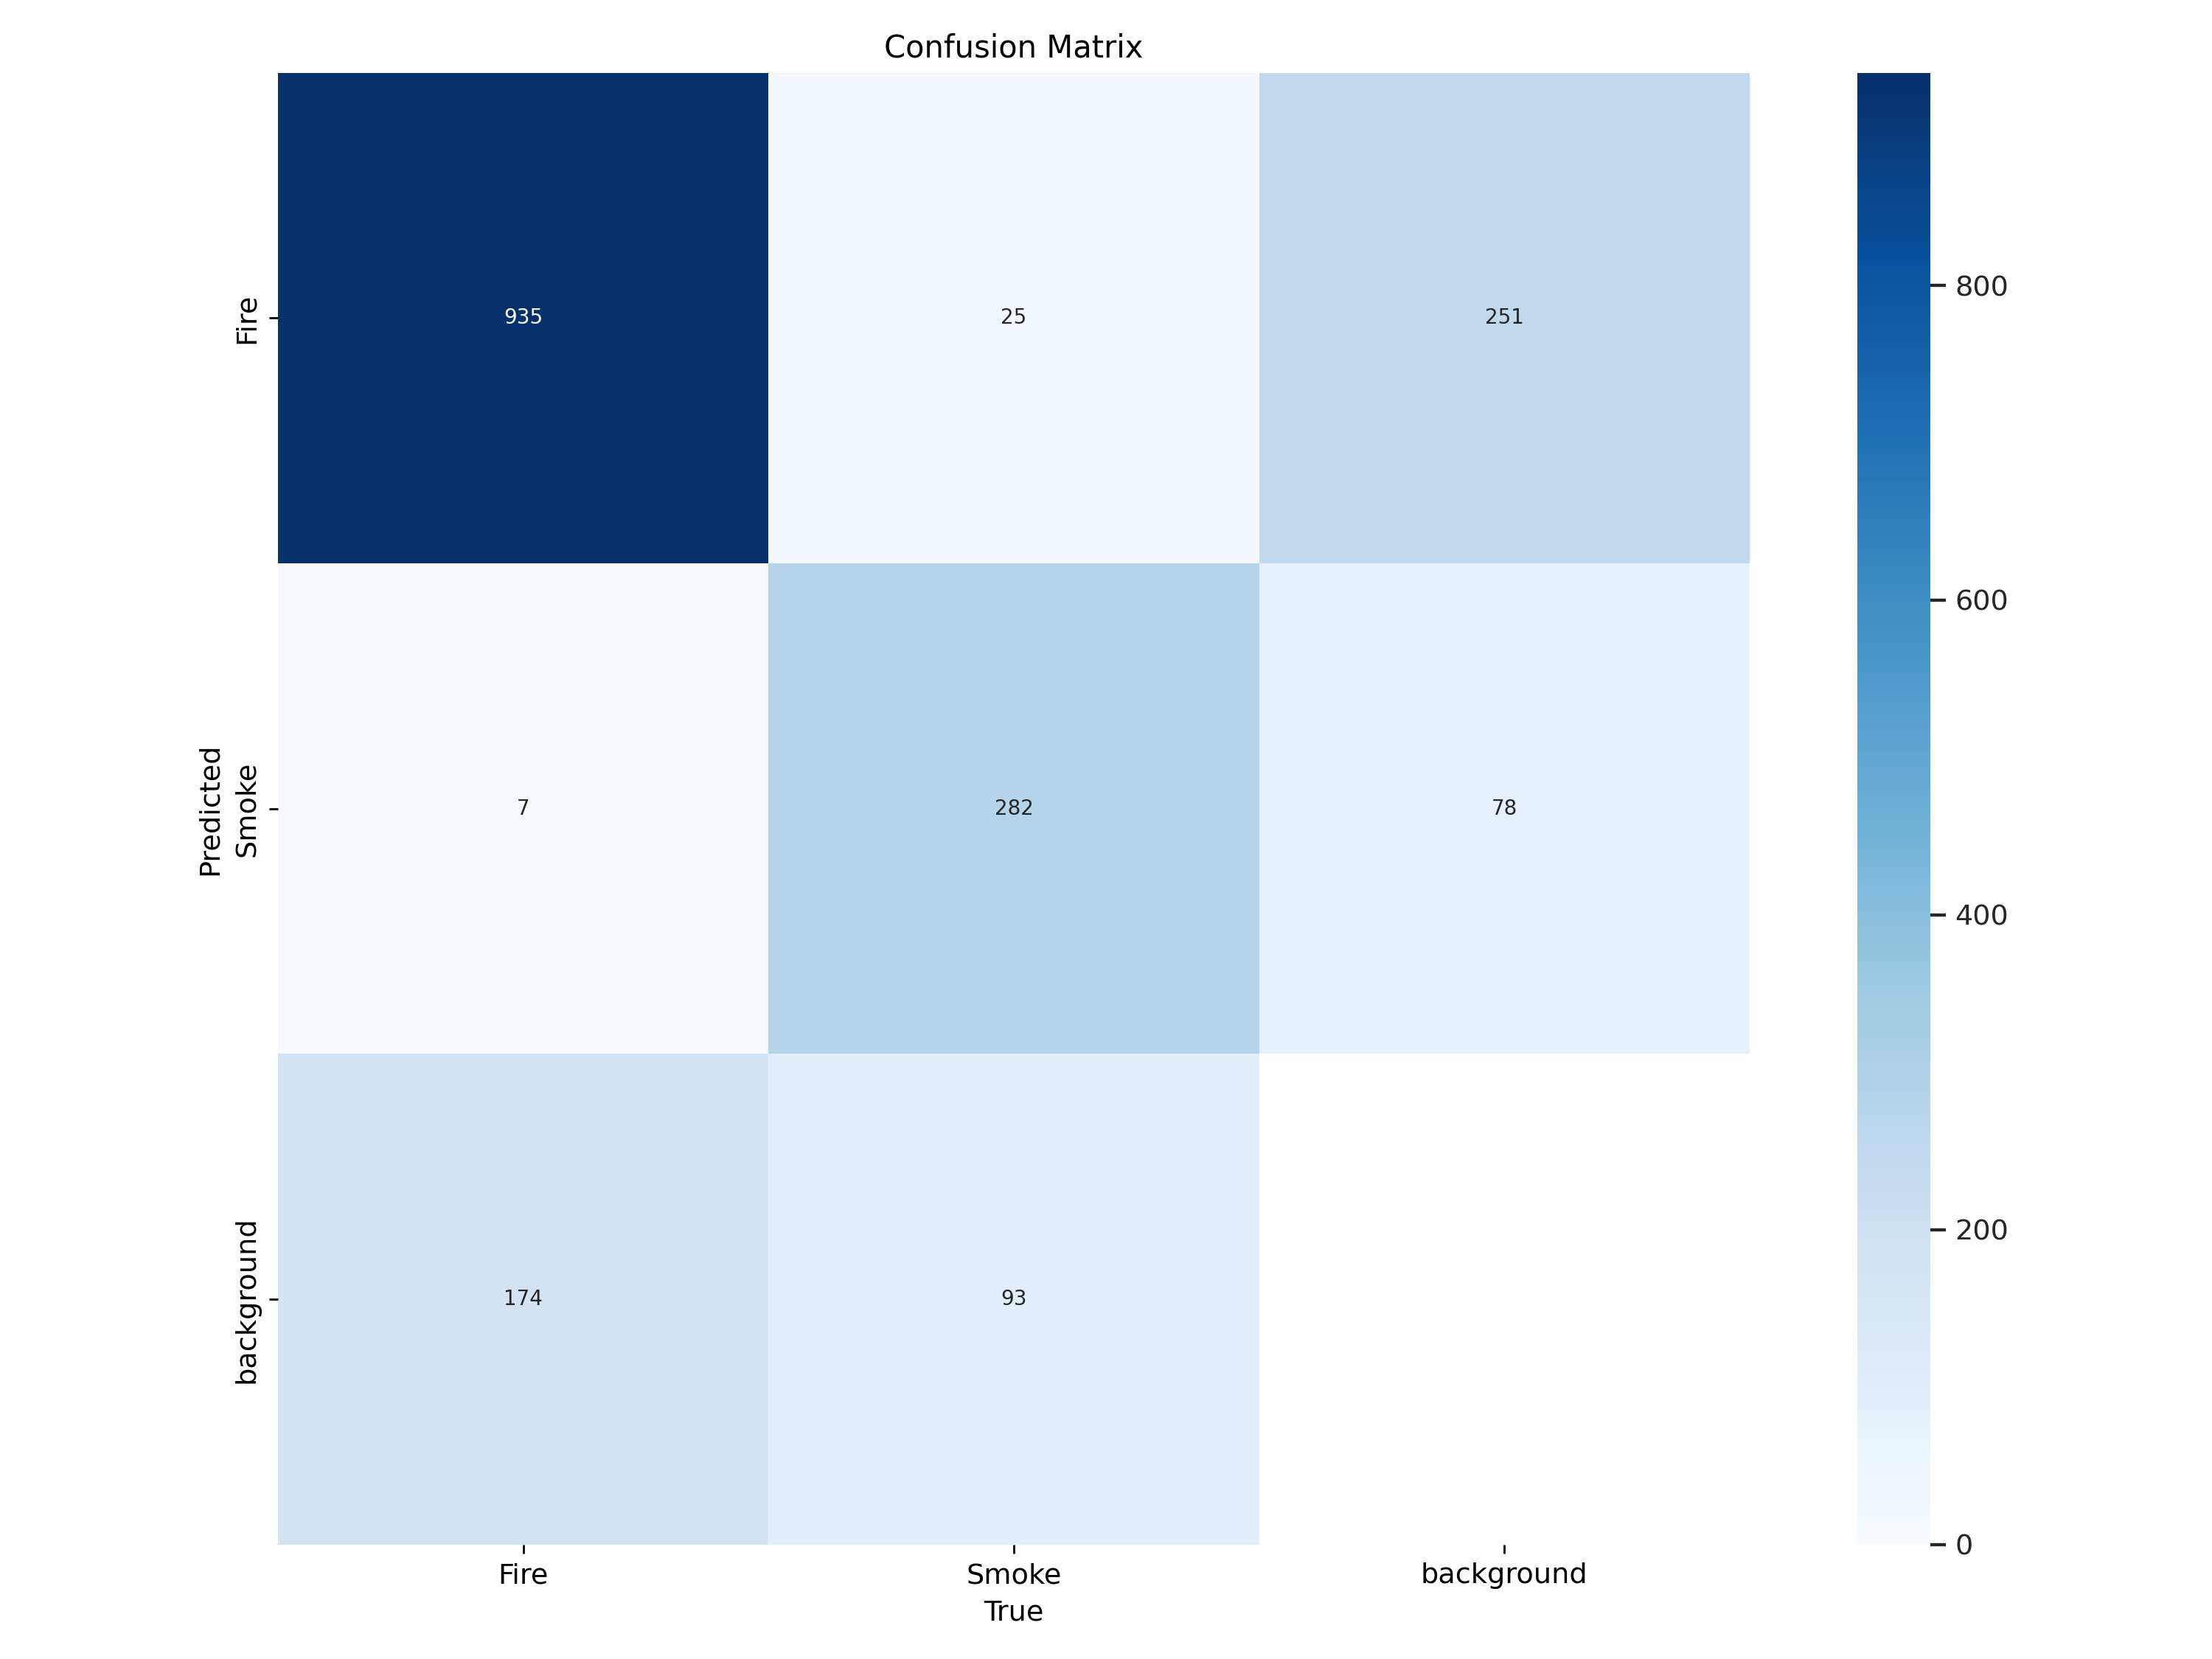

In [10]:
Image("/kaggle/working/runs/detect/train/confusion_matrix.png", width=600)

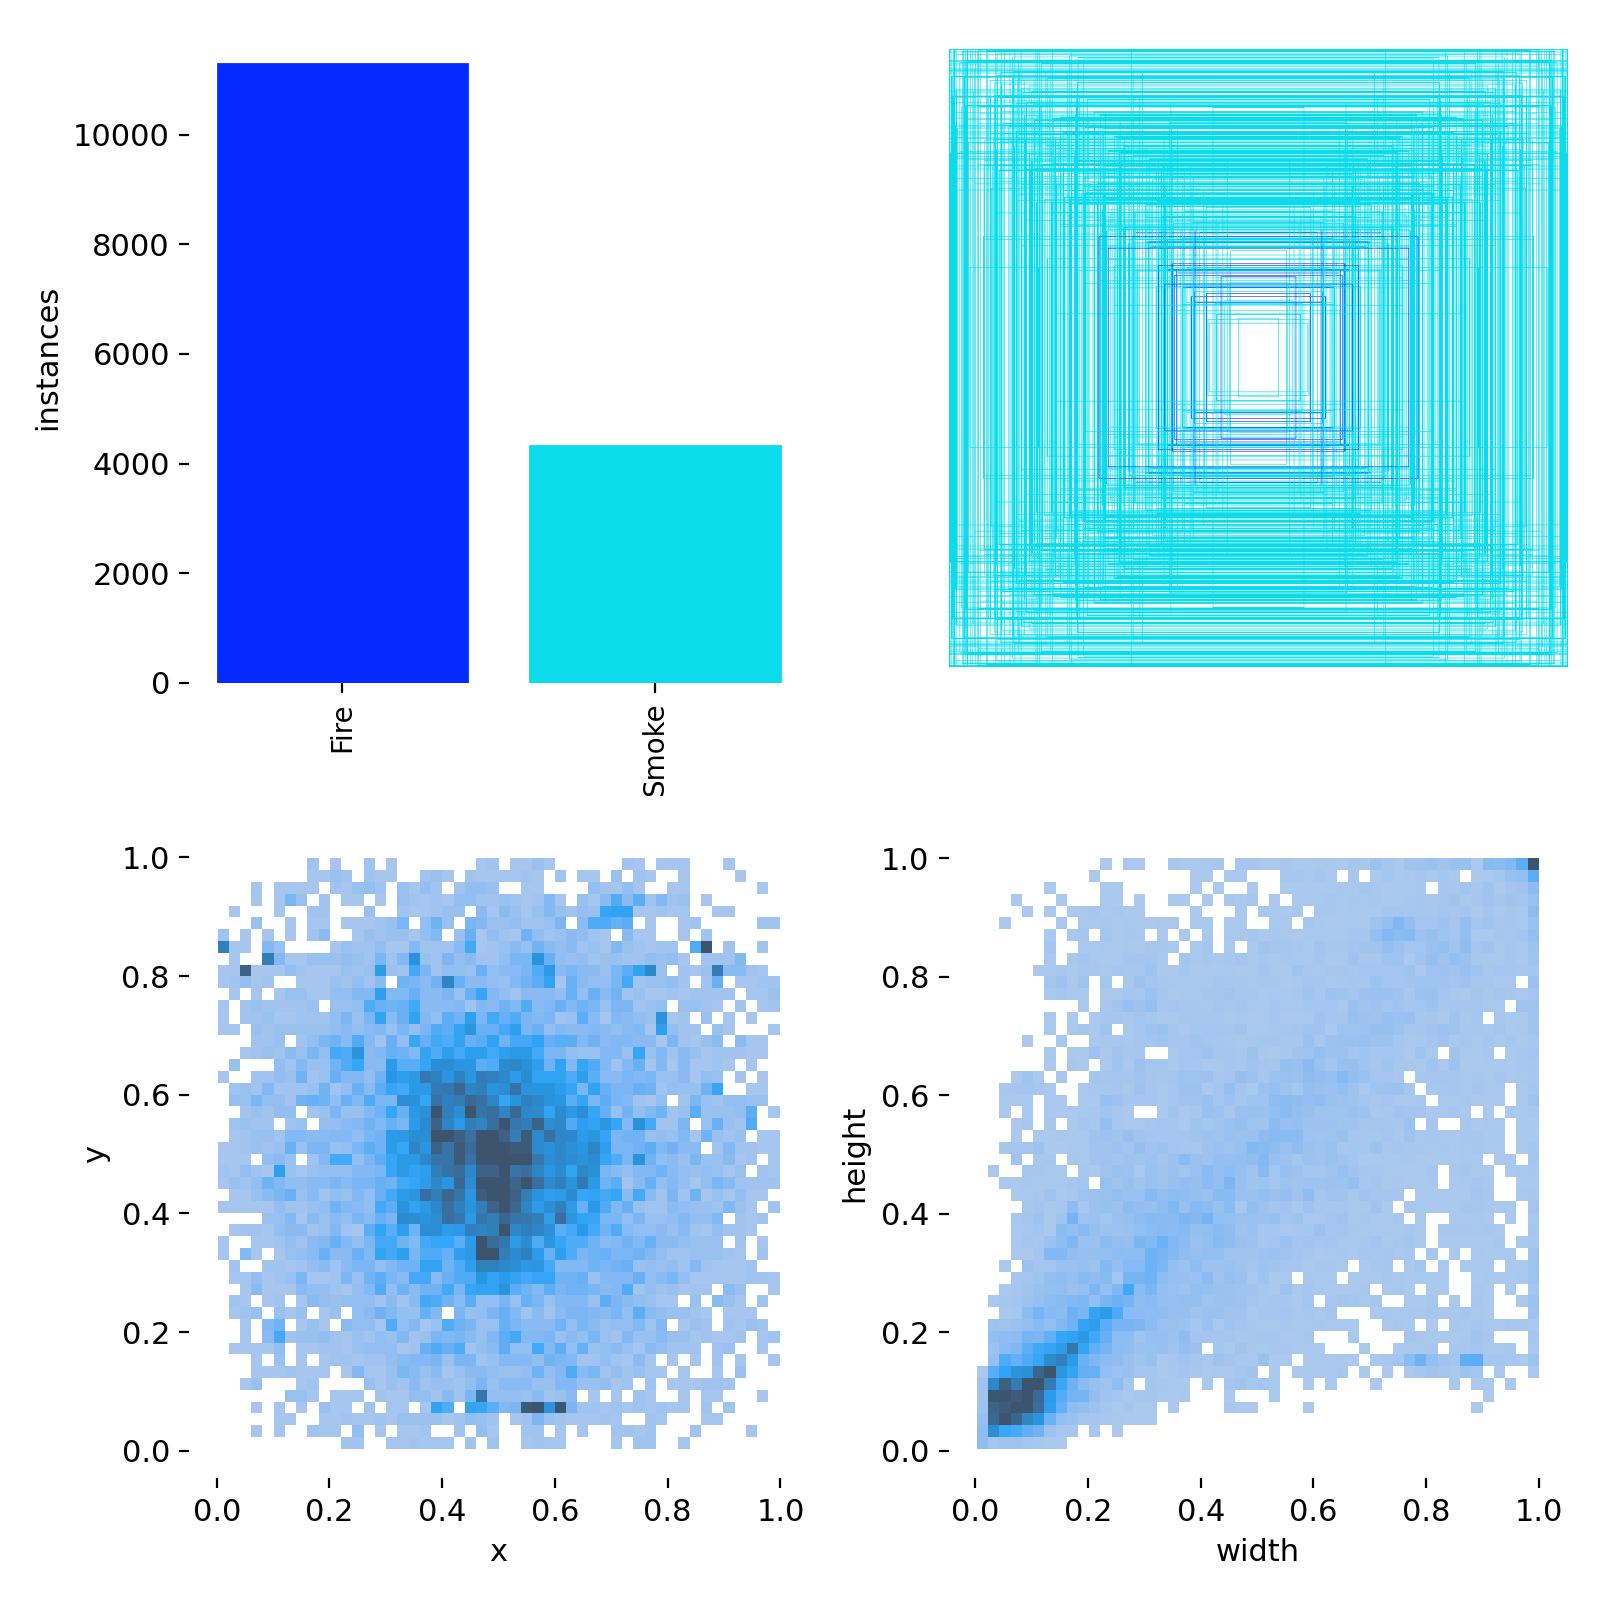

In [11]:
Image("/kaggle/working/runs/detect/train/labels.jpg", width=600)

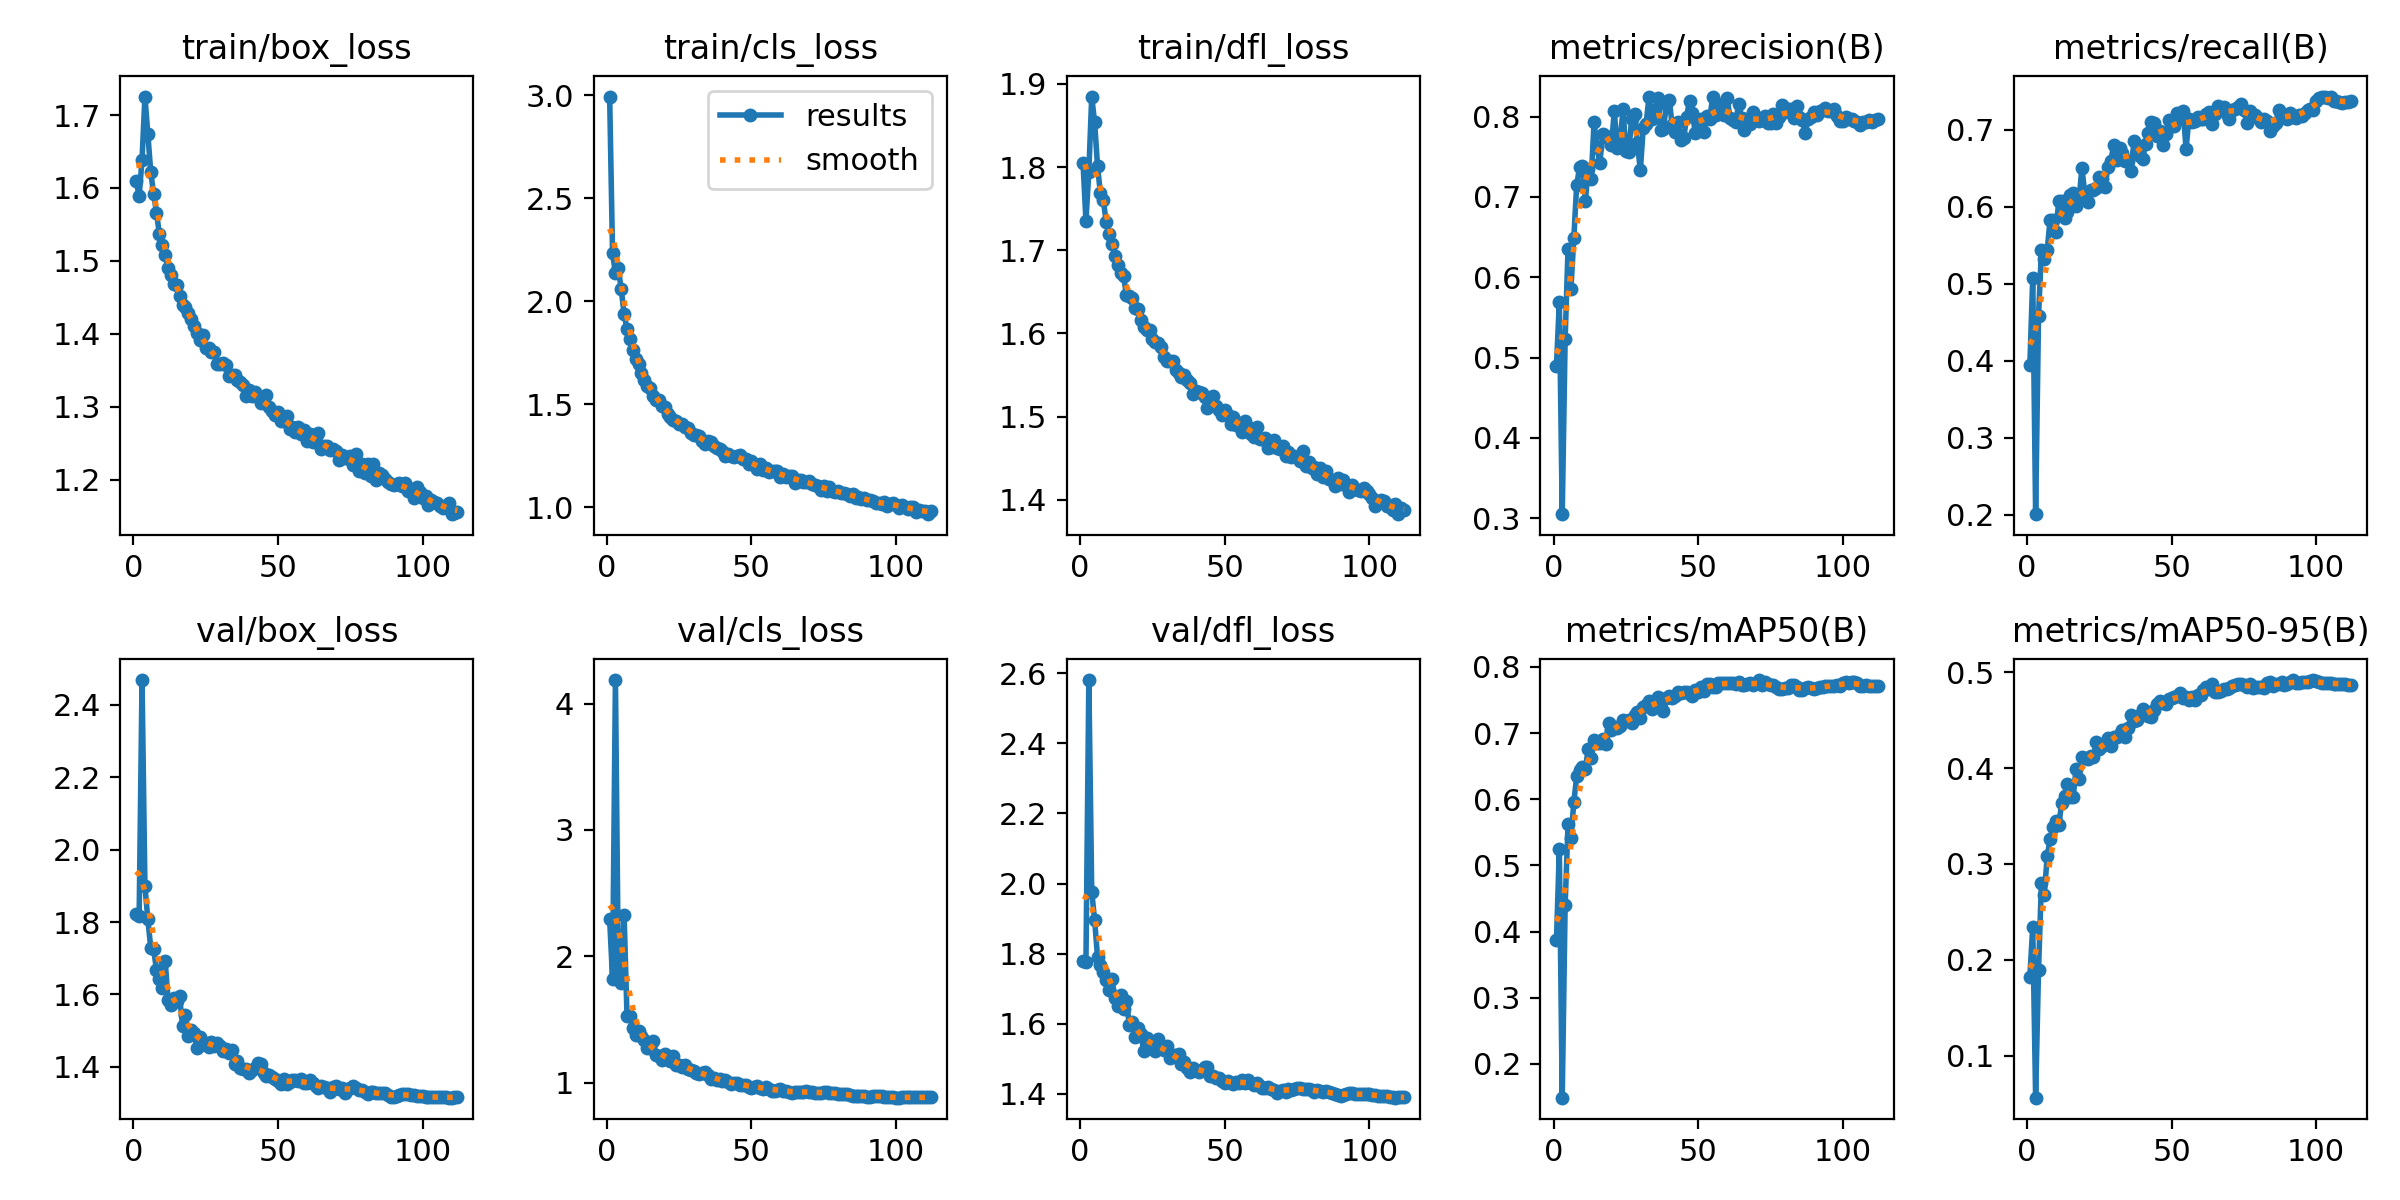

In [12]:
Image("/kaggle/working/runs/detect/train/results.png", width=600)

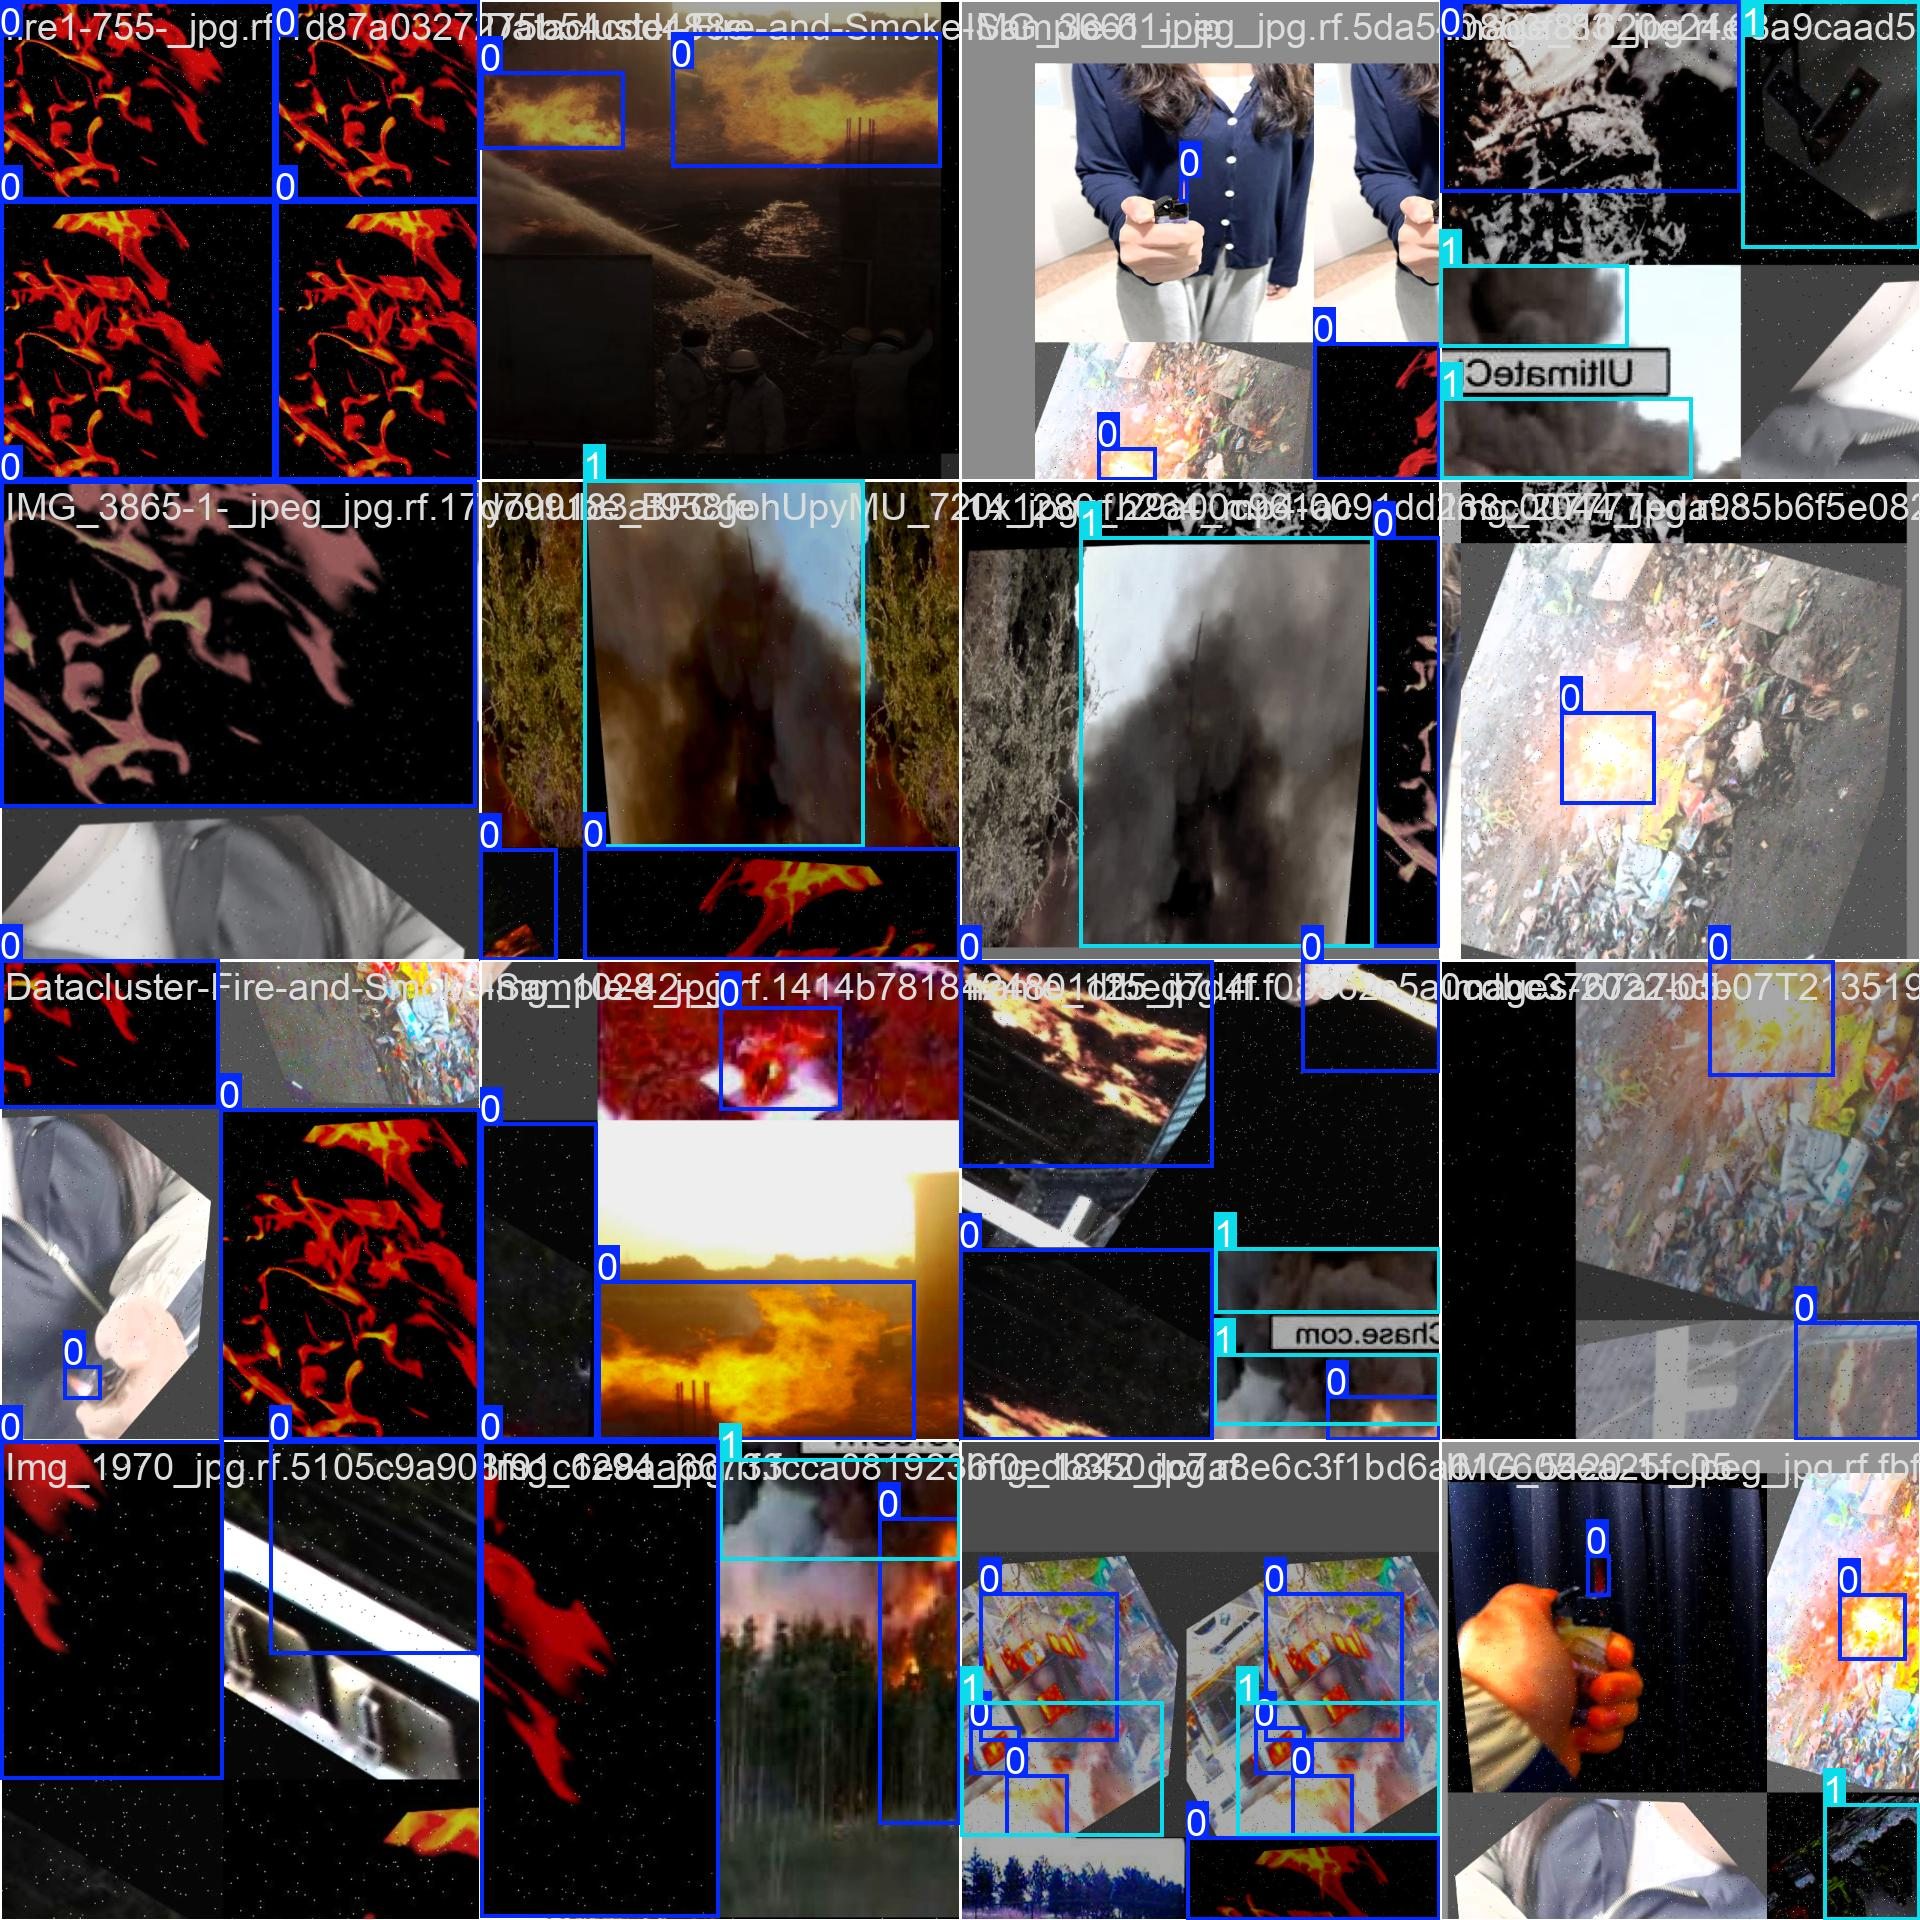

In [13]:
Image("/kaggle/working/runs/detect/train/train_batch0.jpg", width=600)

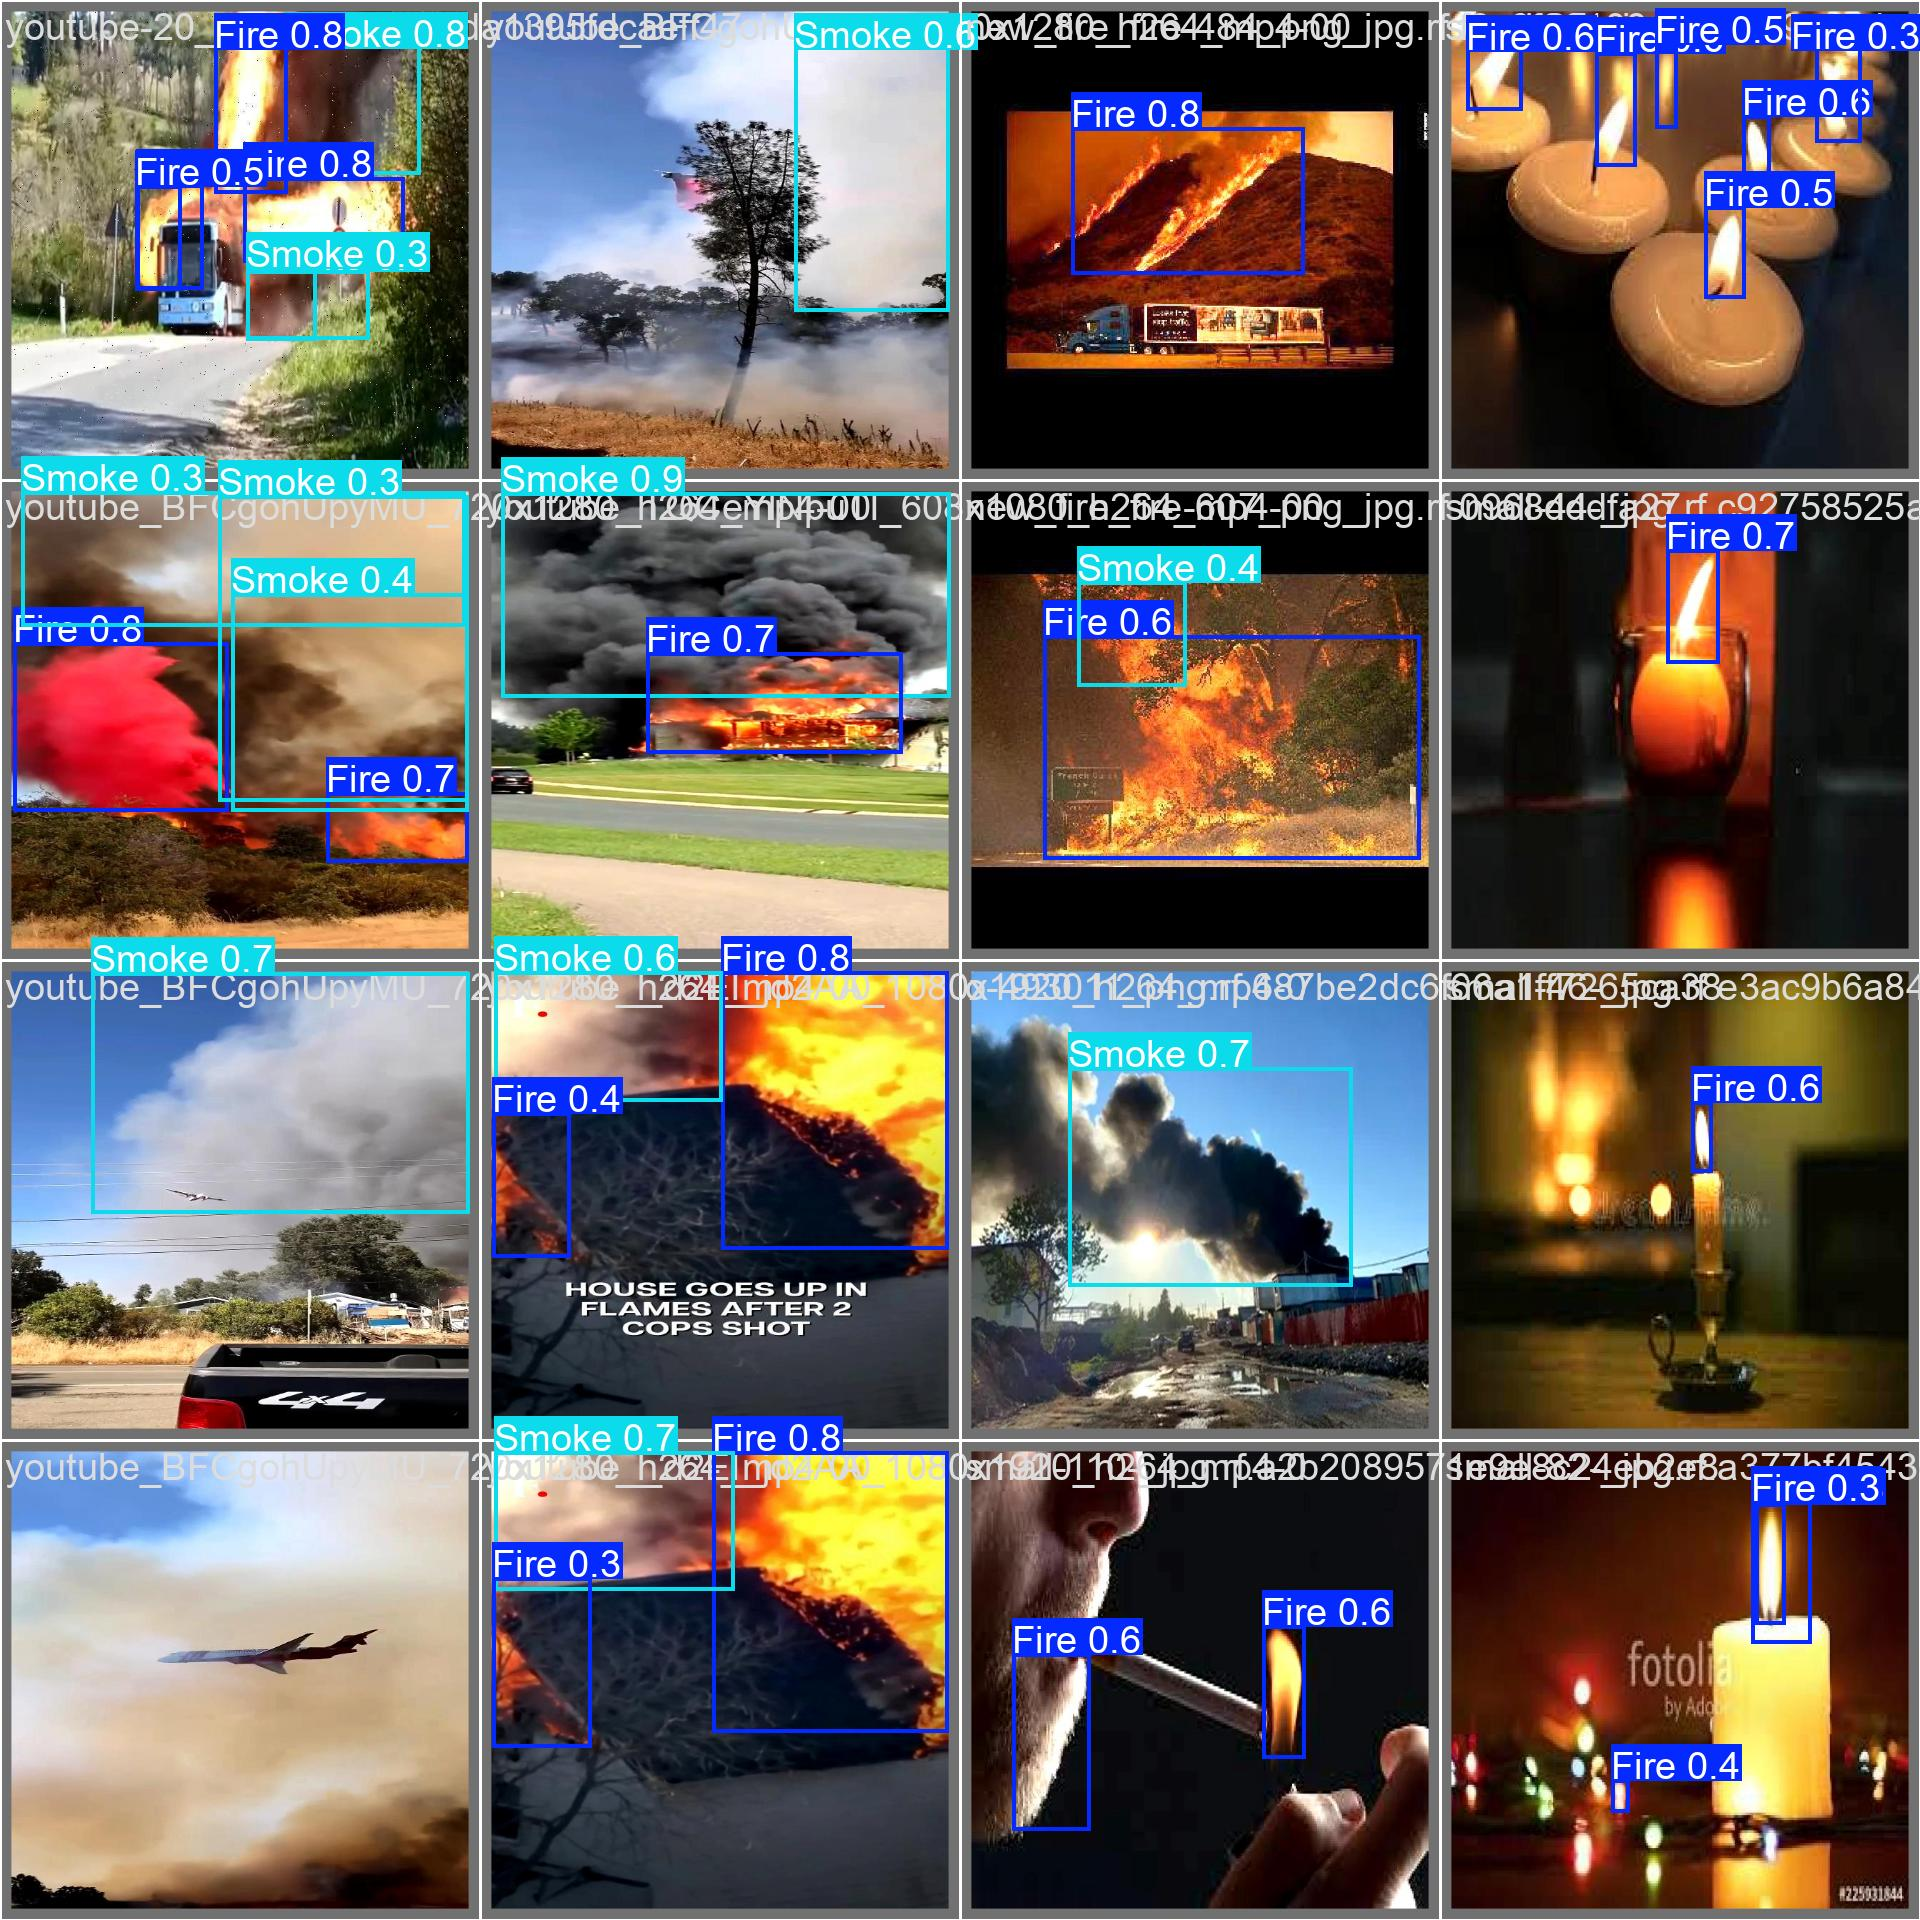

In [14]:
Image("/kaggle/working/runs/detect/train/val_batch0_pred.jpg", width=600)

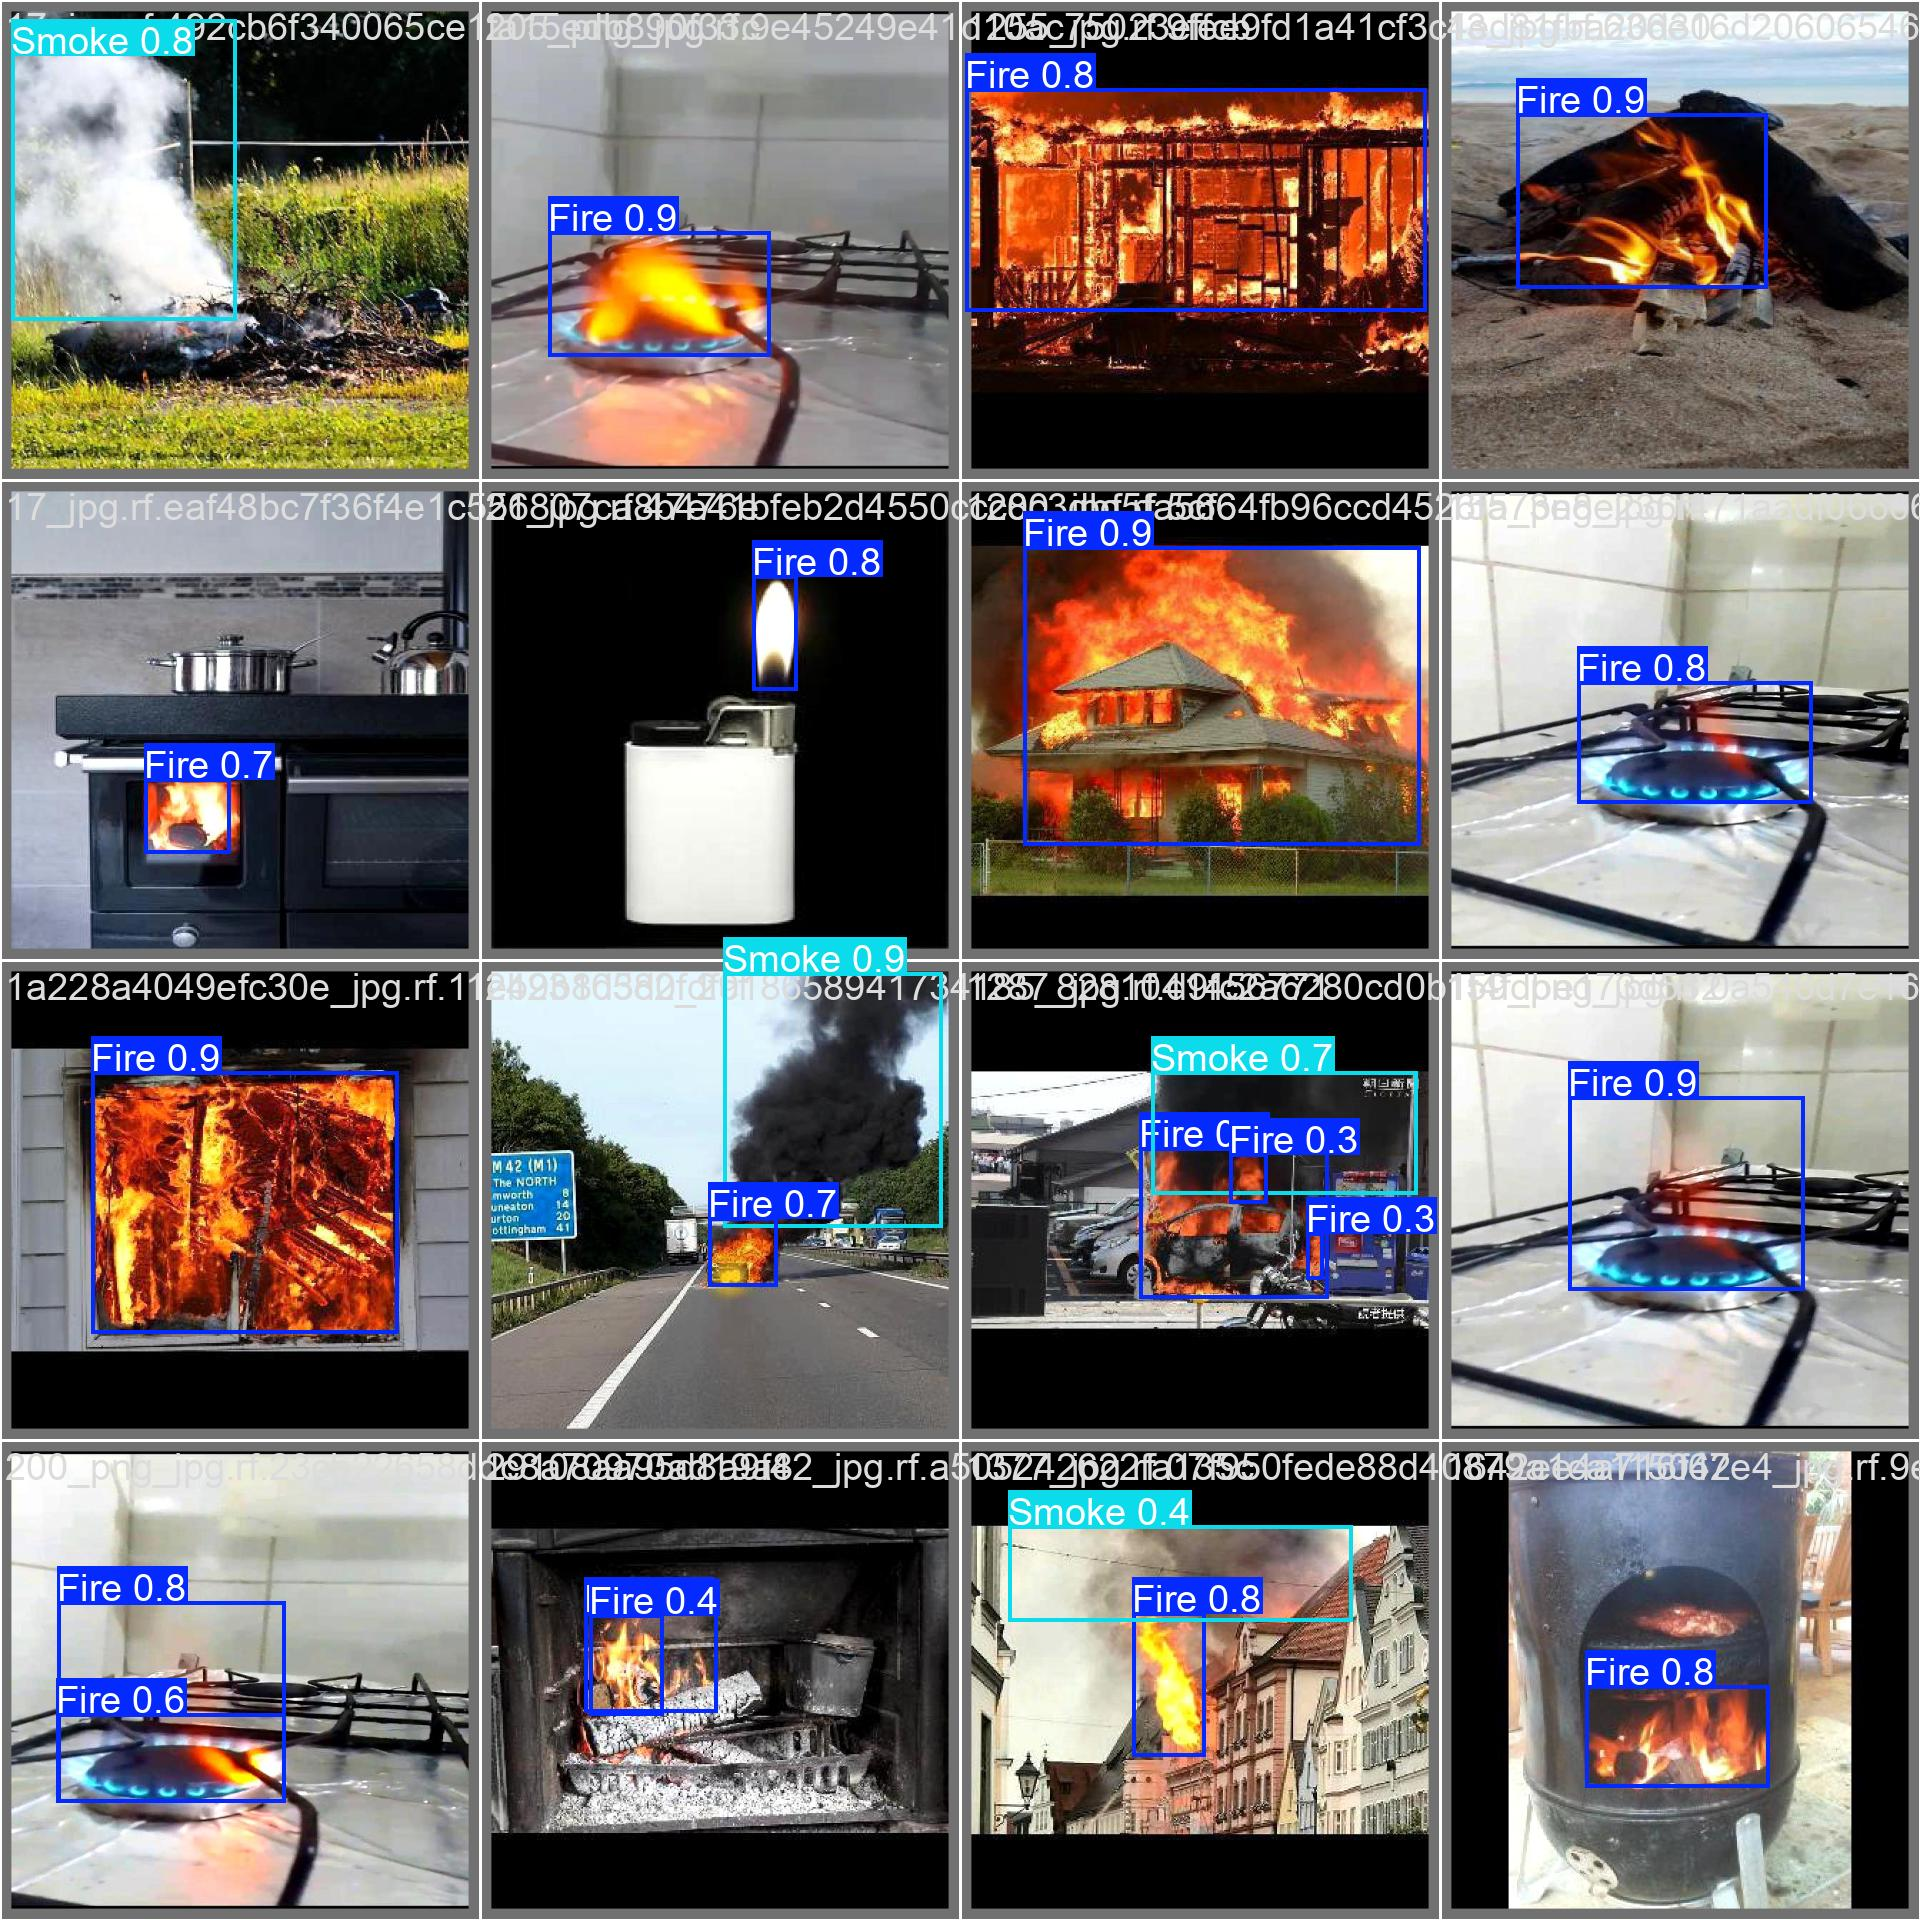

In [15]:
Image("/kaggle/working/runs/detect/train/val_batch1_pred.jpg", width=600)

**Step # 07  Validate Fine-Tuned Model**

In [16]:
!yolo task=detect mode=val model="/kaggle/working/runs/detect/train/weights/best.pt" data={dataset.location}/data.yaml

Ultralytics 8.3.68 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 238 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs
val: Scanning /kaggle/working/Fire-Smoke-Detection-Yolov11-2/valid/labels.cache.
val: WARNING ⚠️ /kaggle/working/Fire-Smoke-Detection-Yolov11-2/valid/images/0111_jpg.rf.df9ecd8f7faed94e97c5a56527701e05.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/Fire-Smoke-Detection-Yolov11-2/valid/images/52_jpg.rf.f27ed8ca965c7261933cc61528cd6a0a.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/Fire-Smoke-Detection-Yolov11-2/valid/images/Img_1060_jpg.rf.d53273be278b74366e9ae2bfca25f709.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/Fire-Smoke-Detection-Yolov11-2/valid/images/Img_1169_jpg.rf.ad38a3b517eeced6a0412e60069c01dc.jpg: 2 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/Fire-Smoke-Detection-Yolov11-2/valid/images/Img_1195_jpg.rf.df9bae398622edee0d6fab36d0fe1a4b

**Step # 08 Inference with Custom Model on Images**

In [17]:
!yolo task=detect mode=predict model="/kaggle/working/runs/detect/train/weights/best.pt" conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.68 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 238 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs

image 1/435 /kaggle/working/Fire-Smoke-Detection-Yolov11-2/test/images/-156123_png.rf.c070b5ca8cd9c6d7cbaadfe0049b6681.jpg: 640x640 1 Smoke, 10.5ms
image 2/435 /kaggle/working/Fire-Smoke-Detection-Yolov11-2/test/images/-189475_png.rf.0febd1e6d6bc9fea1e099f5ddbbb24a7.jpg: 640x640 1 Smoke, 8.8ms
image 3/435 /kaggle/working/Fire-Smoke-Detection-Yolov11-2/test/images/-285365_png.rf.b0659226a5f2b0885993f80e119ded3a.jpg: 640x640 1 Smoke, 7.7ms
image 4/435 /kaggle/working/Fire-Smoke-Detection-Yolov11-2/test/images/-334489_png.rf.f027df96944011227354c03a51bfca37.jpg: 640x640 1 Fire, 1 Smoke, 7.5ms
image 5/435 /kaggle/working/Fire-Smoke-Detection-Yolov11-2/test/images/-370090_png.rf.a4aa3e7ce00632e9b69c6ed0fffa525b.jpg: 640x640 2 Smokes, 8.3ms
image 6/435 /kaggle/working/Fire-Smoke-Detection-Yolov11-2/test/images/-37339

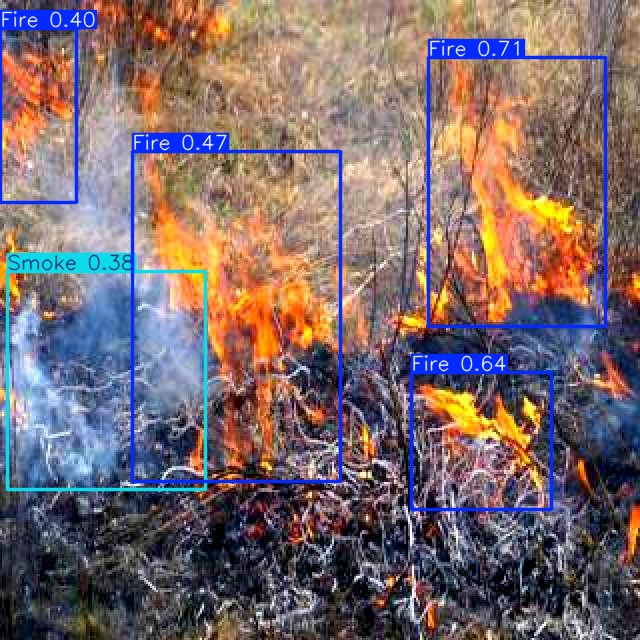

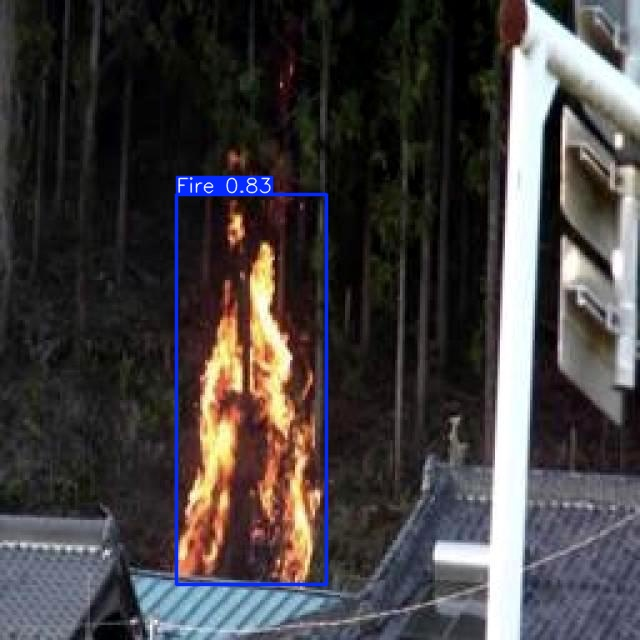

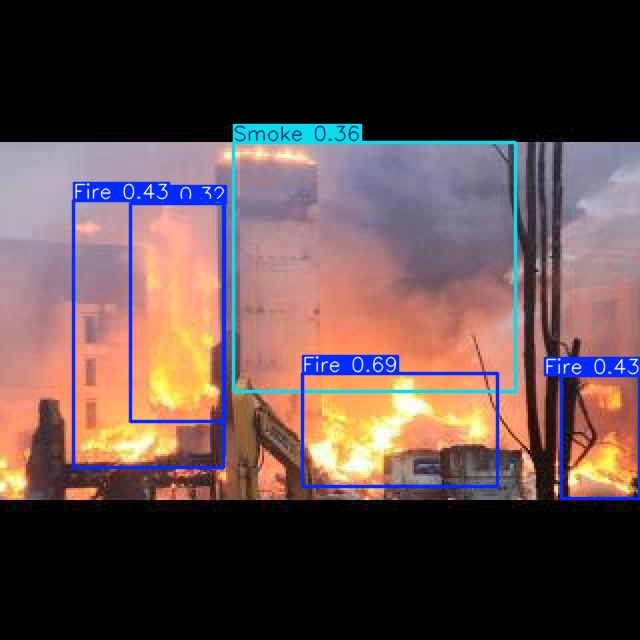

In [18]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob('/kaggle/working/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[1:4]:
    display(IPyImage(filename=img, width=600))
    print("\n")